<a href="https://colab.research.google.com/github/upadhyayprakash/eva4/blob/master/S9/EVA4_Session_9_CIFAR10_RESNet18_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Session-9 Assignment**

1. Move your last code's transformations to Albumentations. Apply ToTensor, HorizontalFlip, Normalize (at min) + More (for additional points)
2. Please make sure that your test_transforms are simple and only using ToTensor and Normalize
3. Implement GradCam function as a module. 
4. Your final code (notebook file) must use imported functions to implement transformations and GradCam functionality
5. Target Accuracy is 87%

 

### **These are the questions in S9-Assignment-Solution**

1. Paste your Albumentation File Code
2. Paste your GradCam Module's code
3. Paste your notebook file code
4. What is your final Validation Accuracy?
5. Share the link to your Repo.

#### **RESULT**
GitHub Source: https://github.com/upadhyayprakash/eva4/tree/master/S9

#### **Summary**

| Metric          | Values         |
| --------------- | -------------- |
| Network Arch.   | **RESNET-18**  |
| # of Epochs     | **20**         |
| # of Parameters | **11,173,962** |
| Final Accuracy  | **88.35%**    |
| Augmentation(Using ALBUMENTATION)    | HorizFlip, ShiftScaleRotate, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness |
| GradCam         | To visualize activation map |

#### Loading the Libraries

In [0]:
# Setting up the module import directory
import sys
sys.path.append('/home/prakash/Prakash/EVA4/Session-9/Notebooks')

In [0]:
# for inline graph plotting
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchsummary import summary

#### Checking if GPU(CUDA) is supported

In [3]:
cuda = torch.cuda.is_available() # returns True/False
print('GPU Available?', cuda)

# initiate the Network
device = torch.device("cuda" if cuda else "cpu")

GPU Available? True


#### Loading and Transforming the CIFAR10 Dataset

In [4]:
# MODULES: Train and Test Data Loaders modules
import data_loader
trainloader = data_loader.getTrainLoader('CIFAR10')
testloader = data_loader.getTestLoader('CIFAR10')

classes = data_loader.getClasses('CIFAR10')

print('Classes: ')
print(classes)

GPU Available? True
Files already downloaded and verified
Files already downloaded and verified
Classes: 
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#### Visualize the training data

Batch Grid


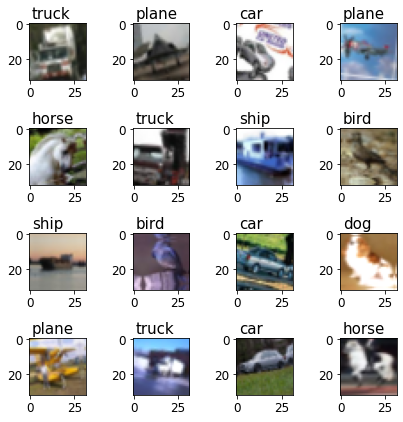

In [5]:
import visualize_data

visualize_data.visualize_batch(trainloader, classes)

### Creating the Network Object

In [6]:
# Loading the Network
# from network import Net
from models.resnet import ResNet18

net = ResNet18().to(device)
summary(net, input_size=(3, 32, 32)) # Network Summary

torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-1

### Training Program

In [7]:
# Model Trainer
import model_trainer
EPOCHS = 20
# Training and Testing the model
traintestresult = model_trainer.fit_model(net, EPOCHS, device, trainloader, testloader, classes)
model = traintestresult['model']

EPOCH: 1
 [================================================================>]  Step: 163ms | Tot: 1m37s | Train Loss: 1.493 | Train Acc: 45.484% (22742/50000) 391/391 
 [================================================================>]  Step: 98ms | Tot: 5s952ms | Test Loss: 1.179 | Test Acc: 57.640% (5764/10000) 79/79 
EPOCH: 2
 [================================================================>]  Step: 167ms | Tot: 1m38s | Train Loss: 1.059 | Train Acc: 62.764% (31382/50000) 391/391 
 [================================================================>]  Step: 101ms | Tot: 5s983ms | Test Loss: 0.817 | Test Acc: 71.580% (7158/10000) 79/79 
EPOCH: 3
 [================================================================>]  Step: 166ms | Tot: 1m38s | Train Loss: 0.860 | Train Acc: 69.804% (34902/50000) 391/391 
 [================================================================>]  Step: 96ms | Tot: 5s983ms | Test Loss: 0.747 | Test Acc: 73.880% (7388/10000) 79/79 
EPOCH: 4
 [===================

### Training Evaluation
Visualizing Training and Testing Results

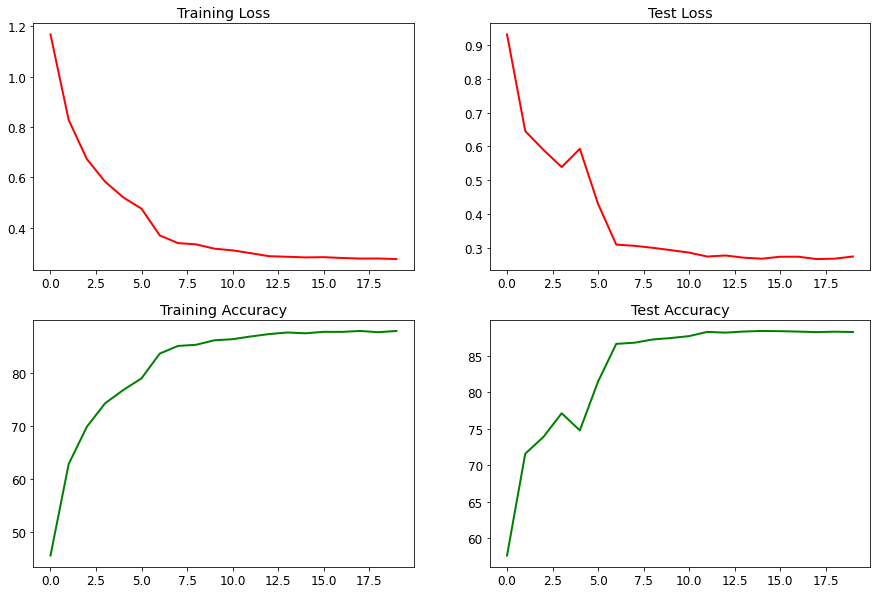

In [8]:
# extract the training/testing metrics
val_acc = traintestresult['val_acc']
val_loss = traintestresult['val_loss']
train_acc = traintestresult['train_acc']
train_loss = traintestresult['train_loss']

# visualize the training/testing stats
visualize_data.visualize_train_test_results(train_acc, train_loss, val_acc, val_loss)

### Class-wise Evaluation Result

Accuracy of plane : 88 %
Accuracy of   car : 91 %
Accuracy of  bird : 74 %
Accuracy of   cat : 70 %
Accuracy of  deer : 89 %
Accuracy of   dog : 87 %
Accuracy of  frog : 91 %
Accuracy of horse : 96 %
Accuracy of  ship : 100 %
Accuracy of truck : 96 %


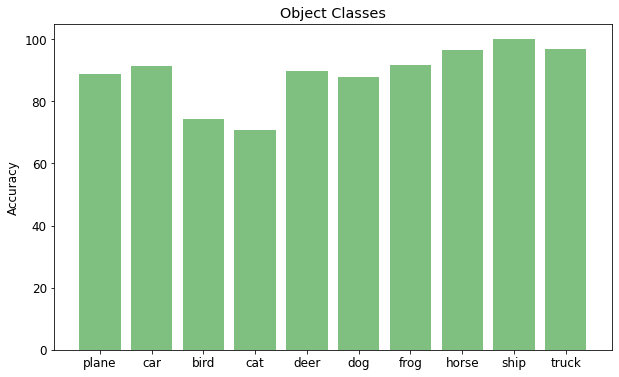

In [9]:
import class_wise_results

class_wise_results.show_class_wise_results(model, testloader, device, classes)

### Plotting Mis-classified Sample Objects

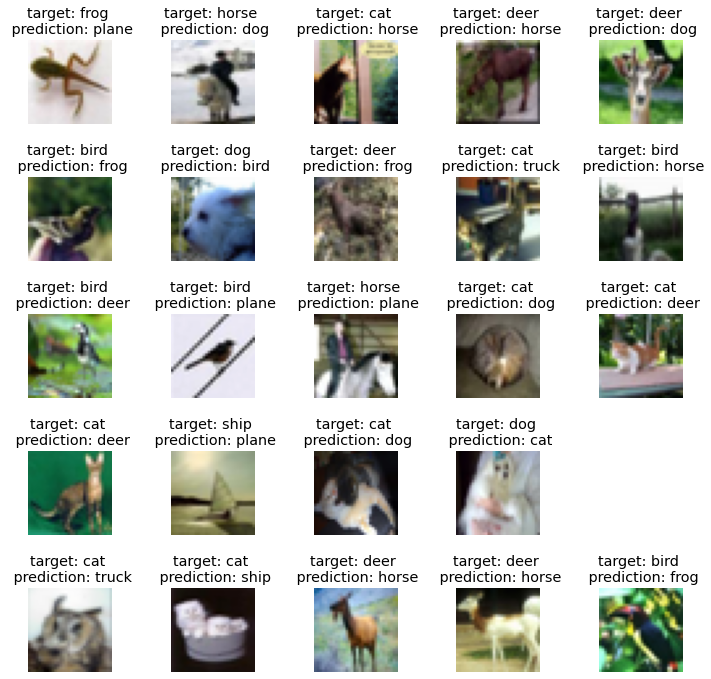

In [10]:
import misclassifieds
# Plotting mis-classified test
misclassifieds.plot_mis_classified_objects(model, device, classes, testloader)

### GradCam Visualization

(220, 52)


/home/prakash/anaconda3/envs/eva4/lib/python3.8/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


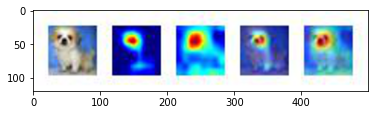

In [11]:
# Visualize the GradCam 
from grad_cam_vis import visualize_grad_cam
%matplotlib inline

visualize_grad_cam(model)